<b>Life Expectancy Predictor</b><br>
<br>
Model predicts expected life expectancy of artist, given provided features in dataset<br>
<b>
1. Load Libraries and data
2. Data preprocessing
3. Modelling part
4. Explainable AI</b>

Used libraries: <i>sklearn, pandas, numpy, xgboost, shap</i><br>
Used model: <i>XGBoostRegressor</i><br>
Explainable AI: <i>shapley values</i><br>

<b>1. Load data, libraries</b>

In [1]:
import pandas as pd
import numpy as np
import sklearn

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

def ReindexDf(df):
    """Reindex dataframe
    """
    ind = [x for x in range(len(df))]
    df['index'] = ind
    df_reindexed = df.set_index('index')
    return df_reindexed

In [14]:
data = pd.read_csv('MetObjects.csv')
df_raw = data.copy()
df_raw.head(2)

<ipython-input-14-69d3765b6f3d>:1: DtypeWarning: Columns (5,7,10,11,12,13,14,34,35,36,37,38,39,40,41,42,43,44,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('MetObjects.csv')


,Object Number,Is Highlight,Is Timeline Work,Is Public Domain,Object ID,Gallery Number,Department,AccessionYear,Object Name,Title,Culture,Period,Dynasty,Reign,Portfolio,Constituent ID,Artist Role,Artist Prefix,Artist Display Name,Artist Display Bio,Artist Suffix,Artist Alpha Sort,Artist Nationality,Artist Begin Date,Artist End Date,Artist Gender,Artist ULAN URL,Artist Wikidata URL,Object Date,Object Begin Date,Object End Date,Medium,Dimensions,Credit Line,Geography Type,City,State,County,Country,Region,Subregion,Locale,Locus,Excavation,River,Classification,Rights and Reproduction,Link Resource,Object Wikidata URL,Metadata Date,Repository,Tags,Tags AAT URL,Tags Wikidata URL
0,1979.486.1,False,False,False,1,NaN,The American Wing,1979.0,Coin,One-dollar Liberty Head Coin,NaN,NaN,NaN,NaN,NaN,16429,Maker,,James Barton Longacre,"American, Delaware County, Pennsylvania 1794–1...",,"Longacre, James Barton",American,1794,1869,NaN,http://vocab.getty.edu/page/ulan/500011409,https://www.wikidata.org/wiki/Q3806459,1853,1853,1853,Gold,Dimensions unavailable,"Gift of Heinz L. Stoppelmann, 1979",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://www.metmuseum.org/art/collection/search/1,NaN,NaN,"Metropolitan Museum of Art, New York, NY",NaN,NaN,NaN
1,1980.264.5,False,False,False,2,NaN,The American Wing,1980.0,Coin,Ten-dollar Liberty Head Coin,NaN,NaN,NaN,NaN,NaN,107,Maker,,Christian Gobrecht,1785–1844,,"Gobrecht, Christian",,1785,1844,NaN,http://vocab.getty.edu/page/ulan/500077295,https://www.wikidata.org/wiki/Q5109648,1901,1901,1901,Gold,Dimensions unavailable,"Gift of Heinz L. Stoppelmann, 1980",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://www.metmuseum.org/art/collection/search/2,NaN,NaN,"Metropolitan Museum of Art, New York, NY",NaN,NaN,NaN


<b>2. Data preprocessing</b>

In [17]:
drop = ['Artist ULAN URL',
'Artist Wikidata URL','Rights and Reproduction','Tags','Tags AAT URL','Tags Wikidata URL','Metadata Date','Object Wikidata URL','Link Resource','Rights and Reproduction',
'Credit Line','Dimensions','Object Number','Object ID','Gallery Number','AccessionYear','Constituent ID']

drop2 = ['Geography Type', 'City', 'State', 'County', 'Country', 'Region','Culture',
         'Subregion', 'Locale', 'Locus', 'Excavation', 'River', 'Classification', 'Repository','Period',
         'Dynasty','Reign','Portfolio','Department','Artist Prefix','Artist Suffix','Artist Display Bio','Artist Gender',
        'Object Name','Title','Medium','Artist Alpha Sort','Object Date','Object Begin Date','Object End Date',
        'Is Highlight','Is Timeline Work','Is Public Domain']

df_temp = df_raw.drop(labels=drop,axis=1)
df_temp = df_temp.drop(labels=drop2,axis=1)
df_temp.head(2)

,Artist Role,Artist Display Name,Artist Nationality,Artist Begin Date,Artist End Date
0,Maker,James Barton Longacre,American,1794,1869
1,Maker,Christian Gobrecht,,1785,1844


In [18]:
df_temp.shape

(477804, 5)

In [19]:
df_temp.isnull().sum()

Artist Role            204368
Artist Display Name    202269
Artist Nationality     202269
Artist Begin Date      202269
Artist End Date        202269
dtype: int64

In [20]:
df_temp.isnull().sum().index

Index(['Artist Role', 'Artist Display Name', 'Artist Nationality', 'Artist Begin Date', 'Artist End Date'], dtype='object')

In [21]:
df_temp = df_temp.dropna(subset=['Artist End Date'])
print('shape: ',df_temp.shape)
df_temp.isnull().sum()

shape:  (275535, 5)


Artist Role            2099
Artist Display Name       0
Artist Nationality        0
Artist Begin Date         0
Artist End Date           0
dtype: int64

Fill remained nan values

In [22]:
mode_role = df_temp['Artist Role'].mode()
mode_role

0    Artist
Name: Artist Role, dtype: object

In [23]:
print("mode artist role: ",mode_role)
df_temp['Artist Role'] = df_temp['Artist Role'].fillna(value='Artist')
df_temp.isnull().sum()

mode artist role:  0    Artist
Name: Artist Role, dtype: object


Artist Role            0
Artist Display Name    0
Artist Nationality     0
Artist Begin Date      0
Artist End Date        0
dtype: int64

In [24]:
df_temp['Artist Nationality'] = df_temp['Artist Nationality'].apply(lambda x: 'American' if x == 'American' else 'European')

In [25]:
df_temp.head(10)

,Artist Role,Artist Display Name,Artist Nationality,Artist Begin Date,Artist End Date
0,Maker,James Barton Longacre,American,1794,1869
1,Maker,Christian Gobrecht,European,1785,1844
9,Maker,Bela Lyon Pratt,European,1867,1917
10,Maker,Christian Gobrecht,European,1785,1844
11,Maker,James Barton Longacre,American,1794,1869
12,Maker,Bela Lyon Pratt,European,1867,1917
13,Maker,Christian Gobrecht,European,1785,1844
32,Maker,James Gillinder and Sons,American,1861,1930
33,Maker,Forestville Manufacturing Company,European,1835,1853
34,Designer|Manufacturer,Paulding Farnham|Tiffany & Co.,European,1859 |1837,1927 |9999


In [28]:
df_temp = ReindexDf(df_temp)
df_temp.head(10)

,Artist Role,Artist Display Name,Artist Nationality,Artist Begin Date,Artist End Date
index,,,,,
0,Maker,James Barton Longacre,American,1794,1869
1,Maker,Christian Gobrecht,European,1785,1844
2,Maker,Bela Lyon Pratt,European,1867,1917
3,Maker,Christian Gobrecht,European,1785,1844
4,Maker,James Barton Longacre,American,1794,1869
5,Maker,Bela Lyon Pratt,European,1867,1917
6,Maker,Christian Gobrecht,European,1785,1844
7,Maker,James Gillinder and Sons,American,1861,1930
8,Maker,Forestville Manufacturing Company,European,1835,1853


___________________
Remove publishers from dataset and create mapping table of artwork

In [29]:
df_temp = df_temp.loc[df_temp['Artist Role']!='Publisher']
map_table = df_temp['Artist Display Name'].value_counts()
map_table = map_table.to_dict()
df_temp = df_temp.drop_duplicates(subset=['Artist Display Name'])

In [30]:
df_temp = ReindexDf(df_temp)

____________
Create new feature - Add number of artworks created

In [31]:
df_temp['ArtWork'] = 0
for i in range(len(df_temp)):
    artist =df_temp['Artist Display Name'][i]
    df_temp['ArtWork'][i]=map_table[artist]
print('done')

<ipython-input-31-d1fc0f6aa93a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['ArtWork'][i]=map_table[artist]


In [42]:
df_temp = ReindexDf(df_temp)
df_temp.head(2)

,Artist Role,Artist Display Name,Artist Nationality,Artist Begin Date,Artist End Date,ArtWork
index,,,,,,
0,Maker,James Barton Longacre,American,1794,1869,2
1,Maker,Christian Gobrecht,European,1785,1844,5


In [43]:
for column in df_temp:
    if df_temp[column].dtype == 'object':
        df_temp[column] = df_temp[column].str.strip() 

In [44]:
import numpy as np
colls = ['Artist Begin Date','Artist End Date']
for coll in colls:
    for i in range(len(df_temp)):
        #print(i)
#         if len(df_temp[coll][i]) != 4:
#             df_temp[coll][i] = np.nan
         if len(df_temp[coll][i]) != 4:
             df_temp[coll][i] = np.nan
print('done')

done


In [45]:
df_temp.isnull().sum()

Artist Role            0
Artist Display Name    0
Artist Nationality     0
Artist Begin Date      0
Artist End Date        0
ArtWork                0
dtype: int64

In [46]:
df_temp.dropna(inplace=True)

In [47]:
df_temp = ReindexDf(df_temp)
df_temp.head(10)

,Artist Role,Artist Display Name,Artist Nationality,Artist Begin Date,Artist End Date,ArtWork
index,,,,,,
0,Maker,James Barton Longacre,American,1794,1869,2
1,Maker,Christian Gobrecht,European,1785,1844,5
2,Maker,Bela Lyon Pratt,European,1867,1917,5
3,Maker,James Gillinder and Sons,American,1861,1930,18
4,Maker,Forestville Manufacturing Company,European,1835,1853,1
5,Maker,Conrad Henninger,European,1885,1932,1
6,Maker,Pierre Stephan,European,1765,1795,3
7,Maker,New England Glass Company,European,1818,1888,112
8,Maker,John Bailey,American,1736,1815,3


In [48]:
df_temp.isnull().sum()

Artist Role            0
Artist Display Name    0
Artist Nationality     0
Artist Begin Date      0
Artist End Date        0
ArtWork                0
dtype: int64

In [49]:
df_temp.shape

(20209, 6)

In [50]:
df_temp = df_temp[df_temp['Artist End Date'] != '9999']

In [51]:
df_temp['Artist End Date'] = df_temp['Artist End Date'].astype('int')

In [52]:
df_temp = df_temp[df_temp['Artist End Date'] < 2022]

In [53]:
df_temp.shape

(17780, 6)

In [54]:
df_temp.isnull().sum()

Artist Role            0
Artist Display Name    0
Artist Nationality     0
Artist Begin Date      0
Artist End Date        0
ArtWork                0
dtype: int64

In [55]:
df_temp.head(10)

,Artist Role,Artist Display Name,Artist Nationality,Artist Begin Date,Artist End Date,ArtWork
index,,,,,,
0,Maker,James Barton Longacre,American,1794,1869,2
1,Maker,Christian Gobrecht,European,1785,1844,5
2,Maker,Bela Lyon Pratt,European,1867,1917,5
3,Maker,James Gillinder and Sons,American,1861,1930,18
4,Maker,Forestville Manufacturing Company,European,1835,1853,1
5,Maker,Conrad Henninger,European,1885,1932,1
6,Maker,Pierre Stephan,European,1765,1795,3
7,Maker,New England Glass Company,European,1818,1888,112
8,Maker,John Bailey,American,1736,1815,3


In [56]:
df_temp['Artist End Date'] = df_temp['Artist End Date'].astype('int')
df_temp['Artist Begin Date'] = df_temp['Artist Begin Date'].astype('int')

In [57]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17780 entries, 0 to 20207
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Artist Role          17780 non-null  object
 1   Artist Display Name  17780 non-null  object
 2   Artist Nationality   17780 non-null  object
 3   Artist Begin Date    17780 non-null  int32 
 4   Artist End Date      17780 non-null  int32 
 5   ArtWork              17780 non-null  int64 
dtypes: int32(2), int64(1), object(3)
memory usage: 833.4+ KB


<b>Create target feature</b>

In [58]:
df_temp['Life'] = - df_temp['Artist Begin Date'] + df_temp['Artist End Date']

In [59]:
df_temp = df_temp[df_temp['Life']<110].copy()
df_final = df_temp.drop('Artist End Date',axis=1)
df_final.head()

,Artist Role,Artist Display Name,Artist Nationality,Artist Begin Date,ArtWork,Life
index,,,,,,
0,Maker,James Barton Longacre,American,1794,2,75
1,Maker,Christian Gobrecht,European,1785,5,59
2,Maker,Bela Lyon Pratt,European,1867,5,50
3,Maker,James Gillinder and Sons,American,1861,18,69
4,Maker,Forestville Manufacturing Company,European,1835,1,18


In [60]:
df_final.shape

(17455, 6)

In [61]:
df_final = df_final.set_index('Artist Display Name')
df_final

,Artist Role,Artist Nationality,Artist Begin Date,ArtWork,Life
Artist Display Name,,,,,
James Barton Longacre,Maker,American,1794,2,75
Christian Gobrecht,Maker,European,1785,5,59
Bela Lyon Pratt,Maker,European,1867,5,50
James Gillinder and Sons,Maker,American,1861,18,69
Forestville Manufacturing Company,Maker,European,1835,1,18
...,...,...,...,...,...
Clarence Frederick Underwood,Artist,European,1871,1,58
Bridge & Beach Manufacturing Co.,Author,European,1837,7,63
"Craftsman Leather Speciality Co., Dayton, Ohio",Author,European,1900,3,50


_____________
Scale numerical features

In [209]:
df_final['Artist Begin Date'] = np.log(df_final['Artist Begin Date'])
df_final['ArtWork'] = np.log(df_final['ArtWork'])
df_final.head()

,Artist Role,Artist Nationality,Artist Begin Date,ArtWork,Life
Artist Display Name,,,,,
James Barton Longacre,Maker,American,-0.356597,NaN,75
Christian Gobrecht,Maker,European,-0.357073,-0.742579,59
Bela Lyon Pratt,Maker,European,-0.352843,-0.742579,50
James Gillinder and Sons,Maker,American,-0.353144,0.059575,69
Forestville Manufacturing Company,Maker,European,-0.354465,NaN,18


_____
Get Categories

In [210]:
df_final.head(3)

,Artist Role,Artist Nationality,Artist Begin Date,ArtWork,Life
Artist Display Name,,,,,
James Barton Longacre,Maker,American,-0.356597,NaN,75
Christian Gobrecht,Maker,European,-0.357073,-0.742579,59
Bela Lyon Pratt,Maker,European,-0.352843,-0.742579,50


In [211]:
categories = ['Artist Role','Artist Nationality'] #'Is Highlight','Is Timeline Work','Is Public Domain',
for item in categories:
    df_final[item] = df_final[item].astype('category')

In [212]:
numerical = ['Artist Begin Date','Life']

In [213]:
df_numerical = df_final[numerical]
df_cat = df_final[categories]
df_cat_dummy = pd.get_dummies(df_cat)
df_cat_dummy.head(2)

,Artist Role_Architect,Artist Role_Armorer,Artist Role_Artist,Artist Role_Artist and architect,Artist Role_Artist and engraver,Artist Role_Artist and publisher,Artist Role_Author,Artist Role_Barrelsmith,Artist Role_Binder,Artist Role_Bladesmith,Artist Role_Calligrapher,Artist Role_Damascener,Artist Role_Decorator,Artist Role_Dedicatee,Artist Role_Department Store,Artist Role_Design House,Artist Role_Designer,Artist Role_Draftsman,Artist Role_Editor,Artist Role_Enameler,Artist Role_Engraver,Artist Role_Entrepreneur,Artist Role_Etcher,Artist Role_Factory,Artist Role_Factory director,Artist Role_Factory owner,Artist Role_Fittings maker,Artist Role_Former Attribution,Artist Role_Founder,Artist Role_Goldsmith,Artist Role_Gunsmith,Artist Role_Hilt Maker,Artist Role_Illustrator,Artist Role_Inventor,Artist Role_Lithographer,Artist Role_Lock maker,Artist Role_Maker,Artist Role_Manufactory,Artist Role_Manufacturer,Artist Role_Modeler,Artist Role_Patentee,Artist Role_Patron,Artist Role_Person in Photograph,Artist Role_Photographer,Artist Role_Photography Studio,Artist Role_Poet,Artist Role_Printer,Artist Role_Printmaker,Artist Role_Purveyor,Artist Role_Retailer,Artist Role_Silversmith,Artist Role_Sitter,Artist Role_Steel-chiseler,Artist Role_Stock maker,Artist Role_Subject,Artist Role_Subject of book,Artist Role_Sword cutler,Artist Role_Sword maker,Artist Role_Swordsmith,Artist Role_Workshop director,Artist Nationality_American,Artist Nationality_European
Artist Display Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
James Barton Longacre,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
Christian Gobrecht,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [214]:
df_model = pd.concat([df_cat_dummy,df_numerical],axis=1)
df_model.head(2)

,Artist Role_Architect,Artist Role_Armorer,Artist Role_Artist,Artist Role_Artist and architect,Artist Role_Artist and engraver,Artist Role_Artist and publisher,Artist Role_Author,Artist Role_Barrelsmith,Artist Role_Binder,Artist Role_Bladesmith,Artist Role_Calligrapher,Artist Role_Damascener,Artist Role_Decorator,Artist Role_Dedicatee,Artist Role_Department Store,Artist Role_Design House,Artist Role_Designer,Artist Role_Draftsman,Artist Role_Editor,Artist Role_Enameler,Artist Role_Engraver,Artist Role_Entrepreneur,Artist Role_Etcher,Artist Role_Factory,Artist Role_Factory director,Artist Role_Factory owner,Artist Role_Fittings maker,Artist Role_Former Attribution,Artist Role_Founder,Artist Role_Goldsmith,Artist Role_Gunsmith,Artist Role_Hilt Maker,Artist Role_Illustrator,Artist Role_Inventor,Artist Role_Lithographer,Artist Role_Lock maker,Artist Role_Maker,Artist Role_Manufactory,Artist Role_Manufacturer,Artist Role_Modeler,Artist Role_Patentee,Artist Role_Patron,Artist Role_Person in Photograph,Artist Role_Photographer,Artist Role_Photography Studio,Artist Role_Poet,Artist Role_Printer,Artist Role_Printmaker,Artist Role_Purveyor,Artist Role_Retailer,Artist Role_Silversmith,Artist Role_Sitter,Artist Role_Steel-chiseler,Artist Role_Stock maker,Artist Role_Subject,Artist Role_Subject of book,Artist Role_Sword cutler,Artist Role_Sword maker,Artist Role_Swordsmith,Artist Role_Workshop director,Artist Nationality_American,Artist Nationality_European,Artist Begin Date,Life
Artist Display Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
James Barton Longacre,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.356597,75
Christian Gobrecht,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.357073,59


Get dataframes for modeling part

In [128]:
X = df_model.drop('Life',axis=1)
y = df_model['Life']

In [129]:
from sklearn.model_selection import train_test_split

In [130]:
X_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=1,shuffle=True)

In [131]:
print(X_train.shape)
print(x_test.shape)

(12218, 63)
(5237, 63)


________
<b>3. Modelling Part</b>

In [198]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.simplefilter(action='ignore')

In [199]:
#Get Baseline
est_baseline = XGBRegressor(max_depth=5,
                        #eta=0.2,
                        #gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        num_round=100,
                  random_seed=1)
est

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=5,
             min_child_weight=6, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, num_round=100,
             random_seed=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.8, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [200]:
est_baseline.fit(X_train,y_train,eval_metric=mean_squared_error)
y_pred = est.predict(x_test)

[14:48:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_round, random_seed } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [201]:
mse = mean_squared_error(y_pred,y_test)
print("baseline model score: ",mse)

baseline model score:  551.4666653850517


____________
Hyperparameter tuning

In [202]:
from sklearn.model_selection import GridSearchCV

In [203]:
params = { 'max_depth': [4,5,6],
          'subsample':[0.7],
           'learning_rate': [0.12],
           'n_estimators': [135],
          'min_child_weight':[5,6],
         'random_seed':[1]}

xgbr = XGBRegressor()
clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)
clf.fit(X_train,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[14:48:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { random_seed } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:48:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { random_seed } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:48:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { random_seed } might not be used.

  This may n

[14:48:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { random_seed } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:48:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { random_seed } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:49:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { random_seed } might not be used.

  This may not be accurate due to some parameters are only used in langu

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
      

In [204]:
clf.best_params_

{'learning_rate': 0.12,
 'max_depth': 4,
 'min_child_weight': 6,
 'n_estimators': 135,
 'random_seed': 1,
 'subsample': 0.7}

In [205]:
clf.best_score_

-527.759474294952

_________
Get final model

In [206]:
#Get final model
estimator = XGBRegressor(max_depth=5,
                        subsample=0.7,
                        n_estimators=135,
                        min_child_weight=6,
                        learning_rate=0.12,
                        random_seed=1)
estimator

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=0.12, max_delta_step=None, max_depth=5,
             min_child_weight=6, missing=nan, monotone_constraints=None,
             n_estimators=135, n_jobs=None, num_parallel_tree=None,
             random_seed=1, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=0.7, tree_method=None,
             validate_parameters=None, verbosity=None)

In [216]:
estimator.fit(X_train,y_train,eval_metric=mean_squared_error)
y_pred = estimator.predict(x_test)

[14:51:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { random_seed } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [217]:
mse = mean_squared_error(y_pred,y_test)
print("model score: ",mse)

model score:  542.5989886276116


Our final model got better score than baseline one (mse 551), this however is not that much difference, there should be done further training, feature engineering and other extensive preprocessing tasks to improve model performance

<b>4. Explainable AI</b> <br>
check feature contribution to final model prediction on test set

In [243]:
import shap

In [240]:
explainer = shap.Explainer(estimator)
shap_values = explainer(x_test)

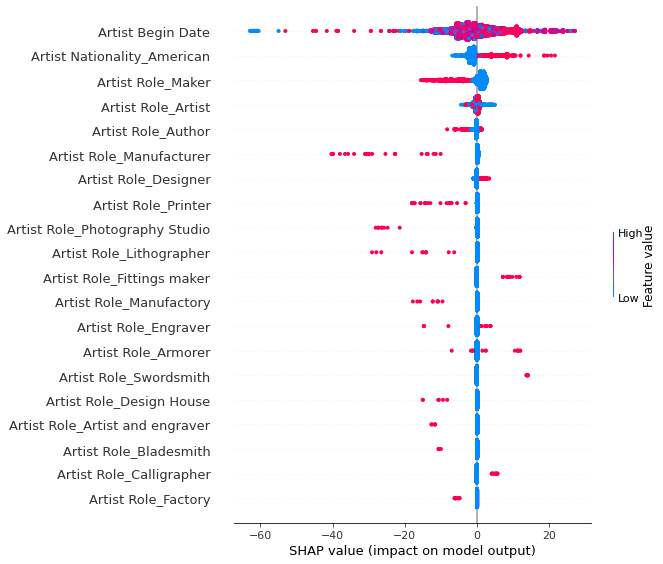

In [241]:
#General data
shap.summary_plot(shap_values)

Get explanation of single model prediction from test set

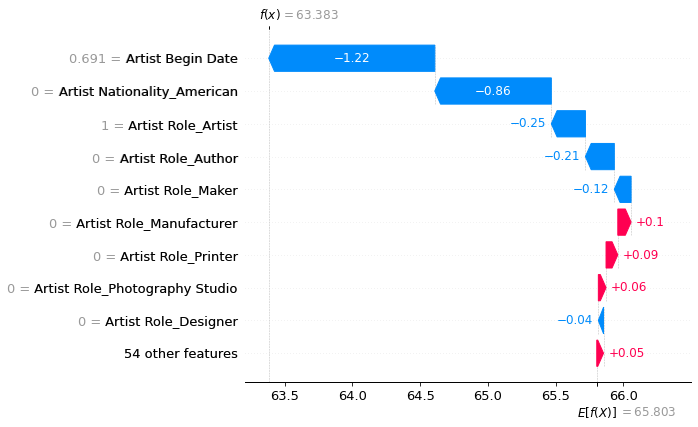

In [248]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[2])

The biggest contribution to prediction on entire test set has 'artist begin date' and 'artist nationality'